# Gradient-Effected Object Recognition Gauge for hive Entrances (GEORGE)
Neural-net-powered honeybee hive-mounted pollen, varroa, and wasp counter

## Imports

In [1]:
import os
import pathlib
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import host_subplot 
import mpl_toolkits.axisartist as AA
import random
import glob
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.builders import model_builder
import pandas as pd
import GEORGE_Library as GEORGE
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

print("Done")

Done


## Define global variables

In [2]:
category_index = {1: {'id': 1, 'name': 'regular'}, 2: {'id': 2, 'name': 'pollen'}, 3: {'id': 3, 'name': 'varroa'}, 4: {'id': 4, 'name': 'wasps'}}
train_augmented_fp = "Dataset/TrainAugmented"
val_augmented_fp = "Dataset/ValAugmented"
IMAGE_WIDTH = 75
IMAGE_HEIGHT = 150
NUM_IMAGES = None
model_directory = 'C:/Users/khard/Documents/GitHub/jupyter/PollenCounter/'
model_name = 'non_extract_non_fill_sub_model'
model_dest = os.path.join(os.sep, model_directory, model_name)
tflite_save = False

# The `label_id_offset` shifts all classes so the model receives one-hot labels where non-background classes start counting at the zeroth index.
label_id_offset = 1
score_threshold = 0.3
batch_size = 64
learning_rate = 0.01
epochs = 2
num_batches = round(len(glob.glob(train_augmented_fp + '/*')) / batch_size) # AKA "Iterations"
num_classes = 4

print("Done")

Done


## Create model and restore weights for all but last layer

This cell builds a single stage detection architecture (RetinaNet) and restores all but the classification layer at the top (which will be automatically randomly initialized).  For simplicity, the image size of 640x640 is hardcoded.

In [3]:
retinapath = pathlib.Path('.').absolute() / "models" / "research" / "object_detection" / "test_data" / "checkpoint"

# Clone the tensorflow models repository if it doesn't already exist
if os.path.exists(retinapath):
    pass
elif not os.path.exists(retinapath):
    !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
    !tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
    !mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

print("Done")

Done


In [4]:
# credit: deeplearning.ai (https://github.com/https-deeplearning-ai)

tf.keras.backend.clear_session()
print('Building model and restoring weights for fine-tuning...', flush=True)
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


## Eager mode custom training loop

In [5]:
# credit: deeplearning.ai (https://github.com/https-deeplearning-ai)

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
    'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
    'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
        to_fine_tune.append(var)

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = GEORGE.get_model_train_step_function(detection_model, optimizer, to_fine_tune)

loss_array = []
file_list = glob.glob(train_augmented_fp + '/*')

print('Start fine-tuning!', flush=True)
for epoch in range(epochs):
    p = np.random.permutation(len(file_list))
    train_random_file_list = [file_list[i] for i in p]
    with tqdm(total = num_batches, unit="batch") as pbar:
        pbar.set_description(desc=("Epoch %i" % (epoch + 1) + "/%i" % epochs))
        for idx in range(num_batches):
            train_images_np = []
            train_labels = []
            gt_boxes = []
            batch_file_list = train_random_file_list[(idx * batch_size):((idx + 1) * batch_size)]
            for filename in batch_file_list:
                temp_info = GEORGE.get_file_and_info(filename)
                train_images_np.append(temp_info[0])
                train_labels.append(temp_info[1])
                gt_boxes.append(temp_info[2])
            train_image_tensors, gt_box_tensors, gt_classes_one_hot_tensors = GEORGE.prep_train_imgs(train_images_np, train_labels, gt_boxes)
            
            # Grab keys for a random subset of examples
            all_keys = list(range(len(train_image_tensors) - 1))
            random.shuffle(all_keys)
            example_keys = all_keys[:batch_size]

            gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
            gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
            image_tensors = [train_image_tensors[key] for key in example_keys]

            # Training step (forward pass + backwards pass)
            total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)
            loss_array.append([total_loss, epoch + 1, idx])
            pbar.set_postfix(loss=total_loss.numpy())
            pbar.update(1)

print('Done fine-tuning!')

Start fine-tuning!


Epoch 2/2: 100%|██████████████████████████████████████████████████████| 141/141 [43:28<00:00, 18.50s/batch, loss=0.363]

Done fine-tuning!


## Save model

In [6]:
@tf.function(input_signature=[tf.TensorSpec(shape=[None,640,640,3], dtype=tf.float32)])

def detect(input_tensor): # credit: deeplearning.ai (https://github.com/https-deeplearning-ai)
    """Run detection on an input image.

    Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

    Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
    """
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    return detection_model.postprocess(prediction_dict, shapes)

if not tflite_save:
    tf.saved_model.save(
        detection_model , model_dest,
        signatures={
          'detect': detect.get_concrete_function()
        })

print("Done")

Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Use fn_output_signature instead


INFO:tensorflow:Assets written to: C:/Users/khard/Documents/GitHub/jupyter/PollenCounter/non_extract_non_fill_sub_model\assets


INFO:tensorflow:Assets written to: C:/Users/khard/Documents/GitHub/jupyter/PollenCounter/non_extract_non_fill_sub_model\assets


Done


In [7]:
if tflite_save:
    # Convert the model
    converter = tf.lite.TFLiteConverter.from_saved_model(model_dest) # path to the SavedModel directory
    tflite_model = converter.convert()

    # Save the model.
    with open('model.tflite', 'wb') as f:
        f.write(tflite_model)

print("Done")

Done


In [3]:
if 'loss_array' in locals() or 'loss_array' in globals():
    y_loss = []
    E_loss = []
    x_loss = []

    for i in loss_array:
        y_loss.append(float(i[0]))
        E_loss.append(i[1])
        x_loss.append(i[2])

    loss_csv = pd.DataFrame()
    loss_csv['y_loss'] = y_loss
    loss_csv['E_loss'] = E_loss
    loss_csv['x_loss'] = x_loss

    print(loss_csv)
    filepath = Path('loss_plot.csv')
    loss_csv.to_csv(filepath)
else:
    loss_array = pd.read_csv('loss_plot.csv')
    y_loss = loss_array["y_loss"]
    E_loss = loss_array["E_loss"]
    x_loss = loss_array["x_loss"]
    
for i in range(len(E_loss)):
    if E_loss[i] == 2:
        x_loss[i] = x_loss[i] + list(E_loss).count(1)
        
print("Done")

Done


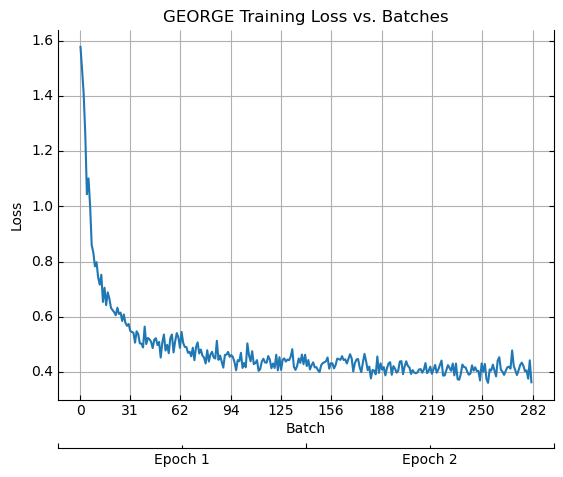

<Figure size 640x480 with 0 Axes>

In [4]:
ax1 = host_subplot(111, axes_class=AA.Axes)
plt.title("GEORGE Training Loss vs. Batches")
ax2 = ax1.twiny()
new_fixed_axis = ax2.get_grid_helper().new_fixed_axis

# First X-axis
ax1.plot(x_loss, y_loss)
ax1.set_xticks([int(i) for i in np.linspace(0, len(x_loss), 10)])
ax1.yaxis.set_label_text("Loss")
ax1.xaxis.set_label_text("Batch")

# Second X-axis
offset = 0, -35 # Position of the second axis
ax2.axis["bottom"] = new_fixed_axis(loc="bottom", axes=ax2, offset=offset)
ax2.axis["top"].set_visible(False)

# Need to change this to scale axis divisions dynamically with different number of epochs
ax2.set_xticks([0, list(E_loss).count(1), len(E_loss)])
ax2.xaxis.set_major_formatter(ticker.NullFormatter())
ax2.xaxis.set_minor_locator(ticker.FixedLocator([len(E_loss)/4, (len(E_loss)/4)*3]))
ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(["Epoch 1", "Epoch 2"]))

ax1.grid(1)
plt.show()
plt.savefig('GEORGE_Loss_vs_Batch.png')